In [1]:
%matplotlib inline

In [2]:
import warnings
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import matplotlib.animation as mpla
import requests
import json
from pprint import pprint
import geopandas as gpd

warnings.filterwarnings("ignore")

# Find out charge status percentages by LGA

In [3]:
xlsx = pd.ExcelFile("../Data/LGA_Criminal_Incidents_Year_Ending_September_2021.xlsx")
charge_status_df = pd.read_excel(xlsx, "Table 05")
charge_status_df

,Year,Year ending,Local Government Area,Charge Status,Incidents Recorded
0,2021,September,Alpine,Charges laid,153
1,2021,September,Alpine,No charges laid,111
2,2021,September,Alpine,Unsolved,107
3,2021,September,Ararat,Charges laid,625
4,2021,September,Ararat,No charges laid,250
...,...,...,...,...,...
2365,2012,September,Yarra Ranges,No charges laid,841
2366,2012,September,Yarra Ranges,Unsolved,2677
2367,2012,September,Yarriambiack,Charges laid,125
2368,2012,September,Yarriambiack,No charges laid,69


In [4]:
# combining charges laid and no charges laid to Solved status
charge_status_df["Charge Status"] = charge_status_df["Charge Status"].str.replace("Charges laid" , "Solved")
charge_status_df["Charge Status"] = charge_status_df["Charge Status"].str.replace("No charges laid" , "Solved")
charge_status_df

,Year,Year ending,Local Government Area,Charge Status,Incidents Recorded
0,2021,September,Alpine,Solved,153
1,2021,September,Alpine,Solved,111
2,2021,September,Alpine,Unsolved,107
3,2021,September,Ararat,Solved,625
4,2021,September,Ararat,Solved,250
...,...,...,...,...,...
2365,2012,September,Yarra Ranges,Solved,841
2366,2012,September,Yarra Ranges,Unsolved,2677
2367,2012,September,Yarriambiack,Solved,125
2368,2012,September,Yarriambiack,Solved,69


In [5]:
# Add up new total columns
charge_by_types = charge_status_df.groupby(["Local Government Area", "Year","Charge Status"])
total_incidents = charge_status_df.groupby(["Local Government Area", "Year"])
charge_by_types_df = pd.DataFrame({"Incidents Combined" : charge_by_types["Incidents Recorded"].sum().astype(int)})

charge_by_types_df["Total Incidents-LGA"] = total_incidents["Incidents Recorded"].sum().astype(int)
charge_by_types_df.reset_index(level = [0,1,2], inplace= True)                                
charge_by_types_df

,Local Government Area,Year,Charge Status,Incidents Combined,Total Incidents-LGA
0,Alpine,2012,Solved,196,311
1,Alpine,2012,Unsolved,115,311
2,Alpine,2013,Solved,219,336
3,Alpine,2013,Unsolved,117,336
4,Alpine,2014,Solved,218,316
...,...,...,...,...,...
1575,Yarriambiack,2019,Unsolved,92,303
1576,Yarriambiack,2020,Solved,222,335
1577,Yarriambiack,2020,Unsolved,113,335
1578,Yarriambiack,2021,Solved,201,319


In [6]:
# Calculate percentage charge status:
charge_by_types_df["Status Percentage"] = round(charge_by_types_df["Incidents Combined"] 
                                                / charge_by_types_df["Total Incidents-LGA"] * 100, 2)
charge_by_types_df

,Local Government Area,Year,Charge Status,Incidents Combined,Total Incidents-LGA,Status Percentage
0,Alpine,2012,Solved,196,311,63.02
1,Alpine,2012,Unsolved,115,311,36.98
2,Alpine,2013,Solved,219,336,65.18
3,Alpine,2013,Unsolved,117,336,34.82
4,Alpine,2014,Solved,218,316,68.99
...,...,...,...,...,...,...
1575,Yarriambiack,2019,Unsolved,92,303,30.36
1576,Yarriambiack,2020,Solved,222,335,66.27
1577,Yarriambiack,2020,Unsolved,113,335,33.73
1578,Yarriambiack,2021,Solved,201,319,63.01


# Combine police stations number and charge status

In [7]:
population_df =  pd.read_csv("../output_data/Population_by_LGA_2012-2021.csv")

In [8]:
population_df

,Year,Local Government Area,Total Population
0,2012,Alpine,12182
1,2012,Ararat,11399
2,2012,Ballarat,96727
3,2012,Banyule,123583
4,2012,Bass Coast,30811
...,...,...,...
785,2021,Wodonga,43147
786,2021,Wyndham,290654
787,2021,Yarra,100852
788,2021,Yarra Ranges,159102


In [9]:
LGA_charge_status_df = pd.merge(population_df, charge_by_types_df , how = "right", on = ["Year", "Local Government Area"])
LGA_charge_status_df

,Year,Local Government Area,Total Population,Charge Status,Incidents Combined,Total Incidents-LGA,Status Percentage
0,2012,Alpine,12182,Solved,196,311,63.02
1,2012,Alpine,12182,Unsolved,115,311,36.98
2,2013,Alpine,12282,Solved,219,336,65.18
3,2013,Alpine,12282,Unsolved,117,336,34.82
4,2014,Alpine,12354,Solved,218,316,68.99
...,...,...,...,...,...,...,...
1575,2019,Yarriambiack,6636,Unsolved,92,303,30.36
1576,2020,Yarriambiack,6587,Solved,222,335,66.27
1577,2020,Yarriambiack,6587,Unsolved,113,335,33.73
1578,2021,Yarriambiack,6445,Solved,201,319,63.01


In [10]:
LGA_charge_status_2021_df = LGA_charge_status_df.loc[LGA_charge_status_df["Year"] == 2021]
LGA_charge_status_2021_df

,Year,Local Government Area,Total Population,Charge Status,Incidents Combined,Total Incidents-LGA,Status Percentage
18,2021,Alpine,13098,Solved,264,371,71.16
19,2021,Alpine,13098,Unsolved,107,371,28.84
38,2021,Ararat,12004,Solved,875,1134,77.16
39,2021,Ararat,12004,Unsolved,259,1134,22.84
58,2021,Ballarat,113350,Solved,3727,7455,49.99
...,...,...,...,...,...,...,...
1539,2021,Yarra,100852,Unsolved,5382,9760,55.14
1558,2021,Yarra Ranges,159102,Solved,3137,5323,58.93
1559,2021,Yarra Ranges,159102,Unsolved,2186,5323,41.07
1578,2021,Yarriambiack,6445,Solved,201,319,63.01


In [11]:
police_stations_df = pd.read_csv("../output_data/Number_of_police_stations_in_each_LGA_2021.csv")

In [12]:
LGA_charge_status_ps_df = pd.merge(police_stations_df, LGA_charge_status_2021_df , how = "right", on = "Local Government Area")

LGA_charge_status_ps_df = LGA_charge_status_ps_df.rename(columns = {"Incidents Combined" : "Incidents Recorded"} )
LGA_charge_status_ps_df

,Local Government Area,Police Stations in LGA,Year,Total Population,Charge Status,Incidents Recorded,Total Incidents-LGA,Status Percentage
0,Alpine,6,2021,13098,Solved,264,371,71.16
1,Alpine,6,2021,13098,Unsolved,107,371,28.84
2,Ararat,4,2021,12004,Solved,875,1134,77.16
3,Ararat,4,2021,12004,Unsolved,259,1134,22.84
4,Ballarat,5,2021,113350,Solved,3727,7455,49.99
...,...,...,...,...,...,...,...,...
153,Yarra,3,2021,100852,Unsolved,5382,9760,55.14
154,Yarra Ranges,10,2021,159102,Solved,3137,5323,58.93
155,Yarra Ranges,10,2021,159102,Unsolved,2186,5323,41.07
156,Yarriambiack,8,2021,6445,Solved,201,319,63.01


In [13]:
charge_solved_df = LGA_charge_status_ps_df.loc[LGA_charge_status_ps_df["Charge Status"] == "Unsolved"]
unsolved_percentage = charge_solved_df["Status Percentage"]
mean_charge = round(np.mean(unsolved_percentage),1)
std_charge = round(np.std(unsolved_percentage, ddof = 0),1)
print(f"Mean solved: {mean_charge}%")
print(f"Median solved: {round(np.median(unsolved_percentage),1)}%")
print(f"Standard deviation: {std_charge}%")

print(f"68% of LGA has solved charge percentage between {mean_charge - std_charge}% and {mean_charge + std_charge}%")
print(f"95% of LGA has solved charge percentage between {mean_charge - 2 * std_charge}% and {mean_charge + 2 * std_charge}%")
print(f"99.7% of LGA has solved charge percentage between {round(mean_charge - 3 * std_charge,1)}% and {mean_charge + 3 * std_charge}%")

Mean solved: 41.5%
Median solved: 40.8%
Standard deviation: 10.4%
68% of LGA has solved charge percentage between 31.1% and 51.9%
95% of LGA has solved charge percentage between 20.7% and 62.3%
99.7% of LGA has solved charge percentage between 10.3% and 72.7%


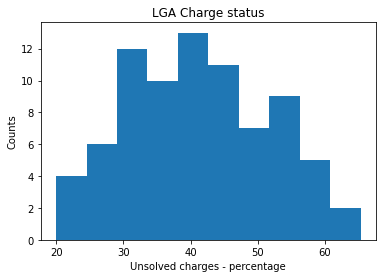

NormaltestResult(statistic=0.13787905442990772, pvalue=0.9333831226485066)


In [14]:
plt.hist(unsolved_percentage)
plt.xlabel("Unsolved charges - percentage")
plt.ylabel("Counts")
plt.style.use("default")
plt.title("LGA Charge status")
plt.show()
print(st.normaltest(unsolved_percentage.sample(50)))

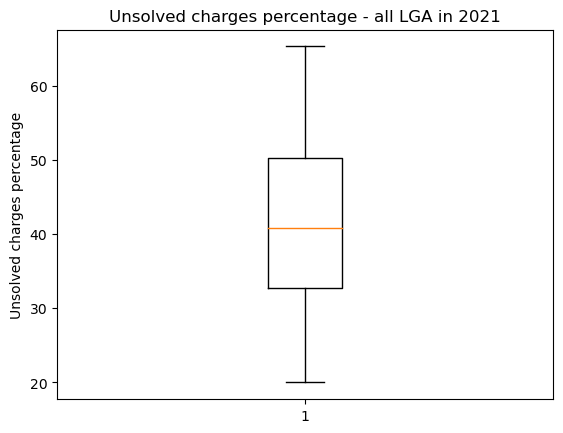

In [15]:
fig , ax = plt.subplots()
ax.set_title("Unsolved charges percentage - all LGA in 2021")
ax.set_ylabel("Unsolved charges percentage")
ax.boxplot(unsolved_percentage)
plt.show()

### Conclusion:
Data is normally distributed, no outliner identified

In [16]:
# setting up function to show scatter plot by year
def scatter_plot(df, year, chargetype, col1, col2):
    new_df = df.loc[(df["Charge Status"] == chargetype) & (df["Year"] == year)]
    title = str(f"{col1} vs {col2} \n {chargetype} charges - {year}")
    new_df.plot(col1, col2, kind = "scatter", xlabel = col1, title = title)
                
    (slope, intercept, rvalue, pvalue, stderr) = linregress(new_df[col1],new_df[col2])
    equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
    x = np.arange(0,new_df[col1].max()+1,1)
    y = [slope * x1 + intercept for x1 in x]
    
    plt.plot(x, y, color = "red" )
    plt.tight_layout()
    plt.style.use("Solarize_Light2")
    plt.annotate(equation, (new_df[col1].max()/3*2 , new_df[col2].max()/3), color = "red")
    print(f"r-value is %.2f" %rvalue)

r-value is -0.45


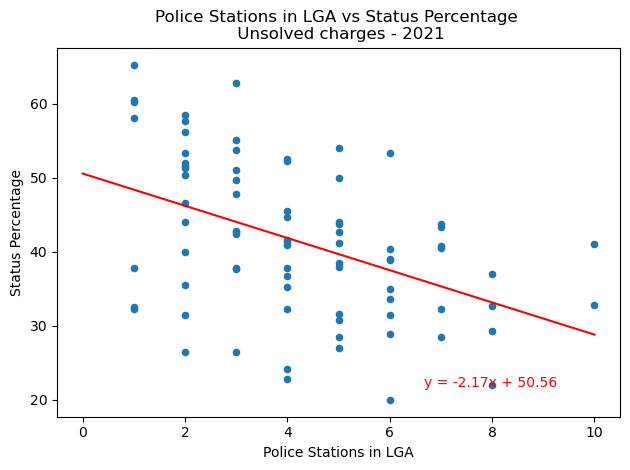

In [17]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Unsolved", "Police Stations in LGA","Status Percentage")


r-value is 0.45


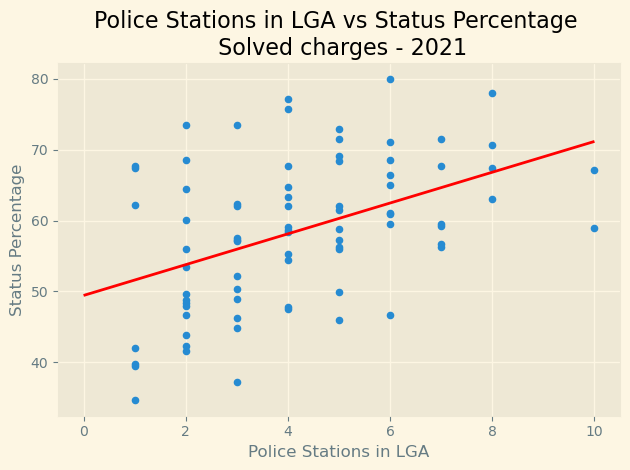

In [18]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Solved", "Police Stations in LGA","Status Percentage")

r-value is 0.50


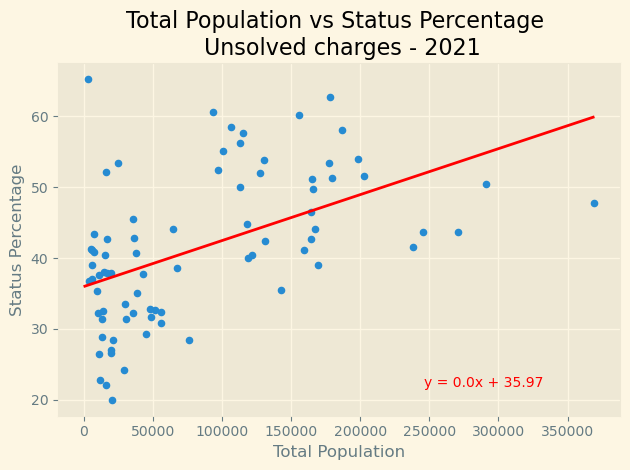

In [19]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Unsolved", "Total Population", "Status Percentage")

r-value is -0.50


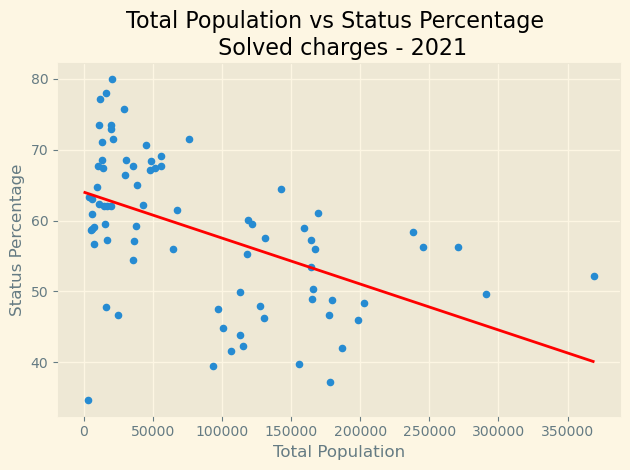

In [20]:
scatter_plot(LGA_charge_status_ps_df, 2021, "Solved", "Total Population", "Status Percentage")

# Getting charge percentage and population dataframe for regions

In [21]:
# Allocate LGA data to regions
LGA_by_Regions_df = pd.read_csv("../Output_data/LGA_by_Regions_2012-2021.csv")
LGA_charge_status_df = LGA_charge_status_df.rename(columns = {"Total Population" : "Total Population-LGA",
                                                              "Incidents Combined" :"Incidents Combined-LGA",
                                                              "Status Percentage" : "Status Percentage-LGA"})
region_charge_status_df = pd.merge(LGA_by_Regions_df, LGA_charge_status_df, how = "right", on = ("Year","Local Government Area"))
region_charge_status_df
                                   

KeyError: 'Local Government Area'

In [ ]:
Regions_population_df = pd.read_csv("../Output_data/Population_by_Regions_2012-2021.csv")
region_charge_pop_df = pd.merge(region_charge_status_df, Regions_population_df , how = "left" , on = ("Police Region", "Year"))
region_charge_pop_df = region_charge_pop_df.rename(columns = {"Total Population":"Total Population-Regions"})

regions_charge_gb = region_charge_pop_df.groupby(["Year", "Police Region", "Charge Status"])

incident_by_charge = regions_charge_gb["Incidents Combined-LGA"].sum()
total_incident_by_region = regions_charge_gb["Total Incidents-LGA"].sum()

regions_charge_df = pd.DataFrame({"Status Percentage-Region": incident_by_charge/total_incident_by_region*100})
regions_charge_df.reset_index(level = [0,1,2],inplace = True)                 
region_charge_pop_df = pd.merge(regions_charge_df, region_charge_pop_df, how = "right" , on = ("Police Region", "Year", "Charge Status"))
region_charge_pop_df

In [ ]:
unsolved_region_charge_pop_df = region_charge_pop_df.loc[region_charge_pop_df["Charge Status"] == "Unsolved"]
unsolved_region_charge_pop_df = unsolved_region_charge_pop_df.drop_duplicates(subset = ("Year","Police Region"), keep = "first")

unsolved_region_charge_pop_df = unsolved_region_charge_pop_df[["Year","Police Region","Status Percentage-Region","Total Population-Regions"]]
unsolved_region_charge_pop_df.head()

In [ ]:
# fig, ax = plt.subplot(figsize = (15,15))

for name, data in unsolved_region_charge_pop_df.groupby("Police Region"):
    plt.plot(data["Year"], data["Status Percentage-Region"], label = name)
plt.xlabel("Year")
plt.ylabel("Status Percentage (%)")
plt.ylim(0,100)
plt.title("Unsolved charges by regions")
plt.style.use("seaborn-notebook")
plt.legend()
plt.show()

In [ ]:
# fig, ax = plt.subplot(figsize = (15,15))

for name, data in unsolved_region_charge_pop_df.groupby("Police Region"):
    plt.plot(data["Year"], data["Total Population-Regions"], label = name)
plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Total Population growth")
plt.style.use("seaborn-notebook")
plt.legend()
plt.show()

# Draw LGA boundaries and show charges status on the map

In [ ]:
# # getting LGA boundaries
# url = "https://data.gov.au/geoserver/vic-local-government-areas-psma-administrative-boundaries/wfs?request=GetFeature&typeName=ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811&outputFormat=json"
# response = requests.get(url).json()

# # # Save response to local Data folder
# with open('../Data/LGA_boundaries.json', 'w') as json_file:
#     json.dump(response, json_file)

In [ ]:
boundaries = gpd.read_file('../Data/LGA_boundaries.json')

LGA_boundaries = boundaries[["vic_lga__3", "geometry"]]
LGA_boundaries = LGA_boundaries.rename(columns = {"vic_lga__3": "LGA"} )

LGA_boundaries["LGA"] = LGA_boundaries["LGA"].str.title()

LGA_boundaries["LGA"] = LGA_boundaries["LGA"].replace("Colac Otway","Colac-Otway")

LGA_boundaries

In [ ]:
solved_charge_percentage = LGA_charge_status_ps_df.loc[LGA_charge_status_ps_df["Charge Status"] == "Unsolved"]
solved_charge_percentage = solved_charge_percentage[["Local Government Area", "Status Percentage"]]
solved_charge_percentage = solved_charge_percentage.rename(columns = {"Local Government Area":"LGA"})
solved_charge_percentage

In [ ]:
LGA_boundaries = LGA_boundaries.merge(solved_charge_percentage,how = "left" , on = "LGA")

In [ ]:
LGA_boundaries.loc[LGA_boundaries["Status Percentage"].isna()]

In [ ]:
LGA_boundaries = LGA_boundaries.dropna()

In [ ]:
LGA_boundaries

In [ ]:
len(LGA_boundaries)

In [ ]:
# There should be 79 LGAs
LGA_boundaries.drop_duplicates(subset="LGA", keep = "first", inplace=True)

In [ ]:
with open('../Data/VMFEAT_POLICE_STATION.json') as f:
    js = json.load(f)
policeStations = gpd.read_file('../Data/VMFEAT_POLICE_STATION.json')

In [ ]:
f, ax = plt.subplots(1, figsize = (15,15))
# plt.style.use("seaborn-notebook") #"Solarize_Light2"
LGA_boundaries.plot("Status Percentage", cmap = "seismic", ax = ax, legend = True, 
                        edgecolor = "black", alpha = 0.5, legend_kwds={'label': "Charge percentage(%)",
                                                                  'orientation': "horizontal"
                                                                      })
policeStations.plot(ax = ax, color = "blue", marker = "*", markersize = 10)
plt.title("Police stations in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})
plt.style.use("seaborn-notebook")#"Solarize_Light2"
# plt.show_legend()
plt.show()

In [ ]:
# # Map for readme file
# LGA_boundaries.explore(scheme="naturalbreaks")

# Getting Administrative Region boundaries

In [ ]:
# # getting regions boundaries
# url = "https://vicroadsopendata-vicroadsmaps.opendata.arcgis.com/datasets/a6e912737f234c5b825242ceb19a33b1_0.geojson?outSR=%7B%22latestWkid%22%3A3111%2C%22wkid%22%3A102171%7D"
# response = requests.get(url).json()

# # # Save response to local Data folder
# with open('../Data/region_boundaries.json', 'w') as json_file:
#     json.dump(response, json_file)

In [ ]:
region_boundaries = gpd.read_file('../Data/region_boundaries.json')

In [ ]:
region_boundaries

In [ ]:
region_boundaries.plot(column = "REG_NAME",cmap = "Paired",legend = True, edgecolor = "red", alpha = 0.5)
plt.title("Administrative boundaries in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})

# Getting Administrative Region boundaries

In [ ]:
# getting region boundaries
LGA_by_Regions_df = LGA_by_Regions_df.loc[LGA_by_Regions_df["Year"]==2021]
LGA_by_Regions_df = LGA_by_Regions_df.rename(columns = {"Local Government Area":"LGA"})

In [ ]:
LGA_by_Regions_df

In [ ]:
regions = LGA_boundaries.merge(LGA_by_Regions_df, how = "left", on = "LGA")

In [ ]:
regions

In [ ]:
regions = regions[["Police Region" , "geometry"]]
PSA_regions_boundaries = regions.dissolve(by = "Police Region")

PSA_regions_boundaries.reset_index(level = [0], inplace= True)

PSA_regions_boundaries

In [ ]:
PSA_regions_boundaries.plot(column = "Police Region",cmap = "Paired",legend = True, edgecolor = "red", alpha = 0.5)
plt.title("Police Service Area boundaries in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})

In [ ]:
f, ax = plt.subplots(1, figsize = (15,15))
plt.style.use("seaborn-notebook") #"Solarize_Light2"
LGA_boundaries.plot("Status Percentage", cmap = "seismic", ax = ax, legend = True, 
                        edgecolor = "black", alpha = 0.5, legend_kwds={'label': "Charge percentage(%)",
                                                                  'orientation': "horizontal",
                                                                      })
PSA_regions_boundaries.plot("Police Region", ax = ax, facecolor = "none", edgecolor = "black", linewidth = 1.2, legend = True)
policeStations.plot(ax = ax, color = "blue", marker = "*", markersize = 10)
plt.title("Police stations in Victoria", fontdict = {'fontsize' : 16, 'color': "blue"})
